# Final Project - Formula 1 Machine Learning

## Project Overview

This project uses historical Formula 1 race data from Kaggle to build a machine learning model that predicts whether a driver will finish in the top 10 in a given race. The dataset includes various race, driver, constructor, and circuit attributes. After preprocessing and feature engineering, classification models such as CatBoost, XGB Classifier and Random Forest were tested and optimized to achieve the best predictive performance.

## Project Objectives

- Predict whether a driver will finish in the top 10 in a Formula 1 race.

- Analyze which features have the most influence on race outcomes.

- Compare the performance of different machine learning models.

## Libraries

In [53]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UnicodeWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import ADASYN
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

## Exploring the data

### Reading the files

In [4]:
circuits=pd.read_csv('Data\circuits.csv')
constructor_results=pd.read_csv('Data\constructor_results.csv')
constructor_standings=pd.read_csv('Data\constructor_standings.csv')
constructors=pd.read_csv('Data\constructors.csv')
driver_standings=pd.read_csv('Data\driver_standings.csv')
drivers=pd.read_csv('Data\drivers.csv')
lap_times=pd.read_csv('Data\lap_times.csv')
pit_stops=pd.read_csv('Data\pit_stops.csv')
qualifying=pd.read_csv('Data\qualifying.csv')
races=pd.read_csv('Data/races.csv')
results=pd.read_csv('Data/results.csv')
seasons=pd.read_csv('Data\seasons.csv')
sprint_results=pd.read_csv('Data\sprint_results.csv')
status=pd.read_csv('Data\status.csv')

### Df - Results

In [5]:
results.head(100)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.3,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,22,3,3,7,11,8,8,8,1.0,58,+71.406,5280857,55,9,1:27.795,218.882,1
96,97,22,14,9,9,10,9,9,9,0.0,58,+75.270,5284721,41,12,1:27.966,218.457,1
97,98,22,15,7,11,8,10,10,10,0.0,58,+76.344,5285795,52,11,1:27.926,218.556,1
98,99,22,18,11,16,13,11,11,11,0.0,57,\N,\N,57,13,1:27.998,218.377,11


In [6]:
results_cleaned=results.drop(columns=['points','laps','time','milliseconds','fastestLap','rank','fastestLapTime',
                                      'fastestLapSpeed','position','positionText','statusId'])

In [7]:
results_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27078 entries, 0 to 27077
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   resultId       27078 non-null  int64 
 1   raceId         27078 non-null  int64 
 2   driverId       27078 non-null  int64 
 3   constructorId  27078 non-null  int64 
 4   number         27078 non-null  object
 5   grid           27078 non-null  int64 
 6   positionOrder  27078 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.4+ MB


In [8]:
results_cleaned[['resultId','raceId','driverId','constructorId']]=results_cleaned[['resultId','raceId','driverId','constructorId']].astype('category')

### Df - Constructors

In [9]:
constructors.head()

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [10]:
constructors_cleaned=constructors.drop(columns=['name','url'])

In [11]:
constructors_cleaned['nationality_constructor']=constructors_cleaned['nationality']

In [12]:
constructors_cleaned=constructors_cleaned.drop(columns=['nationality'])

In [13]:
constructors_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   constructorId            212 non-null    int64 
 1   constructorRef           212 non-null    object
 2   nationality_constructor  212 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.1+ KB


In [14]:
constructors_cleaned['constructorId']=constructors_cleaned['constructorId'].astype('category')

In [15]:
# Merging results + constructors

df_merged = pd.merge(results_cleaned, constructors_cleaned, on='constructorId')

In [16]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27078 entries, 0 to 27077
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   resultId                 27078 non-null  category
 1   raceId                   27078 non-null  category
 2   driverId                 27078 non-null  category
 3   constructorId            27078 non-null  int64   
 4   number                   27078 non-null  object  
 5   grid                     27078 non-null  int64   
 6   positionOrder            27078 non-null  int64   
 7   constructorRef           27078 non-null  object  
 8   nationality_constructor  27078 non-null  object  
dtypes: category(3), int64(3), object(3)
memory usage: 2.7+ MB


### Df - drivers

In [17]:
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [18]:
drivers['nationality_driver']=drivers['nationality']

In [19]:
drivers_cleaned=drivers.drop(columns=['driverRef','number','code','url','nationality'])

In [20]:
drivers_cleaned.head()

,driverId,forename,surname,dob,nationality_driver
0,1,Lewis,Hamilton,1985-01-07,British
1,2,Nick,Heidfeld,1977-05-10,German
2,3,Nico,Rosberg,1985-06-27,German
3,4,Fernando,Alonso,1981-07-29,Spanish
4,5,Heikki,Kovalainen,1981-10-19,Finnish


In [21]:
drivers_cleaned['driverId']=drivers_cleaned['driverId'].astype('category')

In [22]:
# Merging with drivers

df_merged_2=pd.merge(df_merged, drivers_cleaned, on='driverId')

In [23]:
df_merged_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27078 entries, 0 to 27077
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   resultId                 27078 non-null  category
 1   raceId                   27078 non-null  category
 2   driverId                 27078 non-null  category
 3   constructorId            27078 non-null  int64   
 4   number                   27078 non-null  object  
 5   grid                     27078 non-null  int64   
 6   positionOrder            27078 non-null  int64   
 7   constructorRef           27078 non-null  object  
 8   nationality_constructor  27078 non-null  object  
 9   forename                 27078 non-null  object  
 10  surname                  27078 non-null  object  
 11  dob                      27078 non-null  object  
 12  nationality_driver       27078 non-null  object  
dtypes: category(3), int64(3), object(7)
memory usage: 3.5+ MB


### Df - races

In [24]:
races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [25]:
races_cleaned=races.drop(columns=['url','fp1_date','fp1_time','fp2_date','fp2_time','fp3_date','fp3_time',
                                  'quali_date','quali_time','sprint_date','sprint_time'])

In [164]:
races_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raceId     1149 non-null   int64 
 1   year       1149 non-null   int64 
 2   round      1149 non-null   int64 
 3   circuitId  1149 non-null   int64 
 4   name       1149 non-null   object
 5   date       1149 non-null   object
 6   time       1149 non-null   object
dtypes: int64(4), object(3)
memory usage: 63.0+ KB


In [26]:
races_cleaned[['raceId','circuitId']]=races_cleaned[['raceId','circuitId']].astype('category')

In [27]:
# Merging with races

df_merged_3=pd.merge(df_merged_2, races_cleaned, on='raceId')

In [167]:
df_merged_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27078 entries, 0 to 27077
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   resultId                 27078 non-null  category
 1   raceId                   27078 non-null  int64   
 2   driverId                 27078 non-null  category
 3   constructorId            27078 non-null  int64   
 4   number                   27078 non-null  object  
 5   grid                     27078 non-null  int64   
 6   positionOrder            27078 non-null  int64   
 7   constructorRef           27078 non-null  object  
 8   nationality_constructor  27078 non-null  object  
 9   forename                 27078 non-null  object  
 10  surname                  27078 non-null  object  
 11  dob                      27078 non-null  object  
 12  nationality_driver       27078 non-null  object  
 13  year                     27078 non-null  int64   
 14  round 

### Df - circuits

In [168]:
circuits.head()

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [28]:
circuits_cleaned=circuits.drop(columns=['name','url'])

In [170]:
circuits_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   circuitId   77 non-null     int64  
 1   circuitRef  77 non-null     object 
 2   location    77 non-null     object 
 3   country     77 non-null     object 
 4   lat         77 non-null     float64
 5   lng         77 non-null     float64
 6   alt         77 non-null     int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 4.3+ KB


In [29]:
circuits_cleaned['circuitId']=circuits_cleaned['circuitId'].astype('category')

In [30]:
# Merging with circuits

df_merged_4=pd.merge(df_merged_3, circuits_cleaned, on='circuitId')

In [173]:
df_merged_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27078 entries, 0 to 27077
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   resultId                 27078 non-null  category
 1   raceId                   27078 non-null  int64   
 2   driverId                 27078 non-null  category
 3   constructorId            27078 non-null  int64   
 4   number                   27078 non-null  object  
 5   grid                     27078 non-null  int64   
 6   positionOrder            27078 non-null  int64   
 7   constructorRef           27078 non-null  object  
 8   nationality_constructor  27078 non-null  object  
 9   forename                 27078 non-null  object  
 10  surname                  27078 non-null  object  
 11  dob                      27078 non-null  object  
 12  nationality_driver       27078 non-null  object  
 13  year                     27078 non-null  int64   
 14  round 

In [31]:
df_merged_4[['raceId','constructorId']]=df_merged_4[['raceId','constructorId']].astype('category')

## First feature engineering

### Pilot age

In [32]:
df_merged_4["dob"] = pd.to_datetime(df_merged_4["dob"])
df_merged_4["date"] = pd.to_datetime(df_merged_4["date"])


df_merged_4["pilot_age"] = df_merged_4.apply(lambda row: 
    row["date"].year - row["dob"].year - ((row["date"].month, row["date"].day) < (row["dob"].month, row["dob"].day)),
    axis=1
)

### Driver home race

In [33]:
#Checking all drivers nationality

df_merged_4['nationality_driver'].unique()

array(['British', 'German', 'Spanish', 'Finnish', 'Japanese', 'French',
       'Polish', 'Brazilian', 'Italian', 'Australian', 'Austrian',
       'American', 'Dutch', 'Colombian', 'Portuguese', 'Canadian',
       'Indian', 'Hungarian', 'Irish', 'Danish', 'Malaysian', 'Argentine',
       'Czech', 'Belgian', 'Swiss', 'Monegasque', 'Swedish', 'Venezuelan',
       'New Zealander', 'Chilean', 'Mexican', 'South African',
       'Liechtensteiner', 'Rhodesian', 'American-Italian', 'Uruguayan',
       'Argentine-Italian', 'Thai', 'East German', 'Russian',
       'Indonesian', 'Chinese', 'Argentinian '], dtype=object)

In [34]:
nationality_to_country = {
    'British': 'United Kingdom',
    'German': 'Germany',
    'Spanish': 'Spain',
    'Finnish': 'Finland',
    'Japanese': 'Japan',
    'French': 'France',
    'Polish': 'Poland',
    'Brazilian': 'Brazil',
    'Italian': 'Italy',
    'Australian': 'Australia',
    'Austrian': 'Austria',
    'American': 'USA',
    'Dutch': 'Netherlands',
    'Colombian': 'Colombia',
    'Portuguese': 'Portugal',
    'Canadian': 'Canada',
    'Indian': 'India',
    'Hungarian': 'Hungary',
    'Irish': 'Ireland',
    'Danish': 'Denmark',
    'Malaysian': 'Malaysia',
    'Argentine': 'Argentina',
    'Czech': 'Czech Republic',
    'Belgian': 'Belgium',
    'Swiss': 'Switzerland',
    'Monegasque': 'Monaco',
    'Swedish': 'Sweden',
    'Venezuelan': 'Venezuela',
    'New Zealander': 'New Zealand',
    'Chilean': 'Chile',
    'Mexican': 'Mexico',
    'South African': 'South Africa',
    'Liechtensteiner': 'Liechtenstein',
    'Rhodesian': 'Zimbabwe',
    'American-Italian': 'USA',
    'Uruguayan': 'Uruguay',
    'Argentine-Italian': 'Argentina',
    'Thai': 'Thailand',
    'East German': 'Germany',
    'Russian': 'Russia',
    'Indonesian': 'Indonesia',
    'Chinese': 'China',
    'Argentinian ': 'Argentina'  # with trailing space
}

In [35]:
# Creating a column for the drivers country

df_merged_4["driver_country"] = df_merged_4["nationality_driver"].str.strip().map(nationality_to_country)

In [36]:
df_merged_4["driver_home_race"] = df_merged_4["driver_country"] == df_merged_4["country"]

### Constructor home race

In [37]:
# Checking all constructors nationality

df_merged_4['nationality_constructor'].unique()

array(['British', 'German', 'French', 'Italian', 'Japanese', 'Austrian',
       'Indian', 'Dutch', 'Russian', 'Swiss', 'Irish', 'Hong Kong',
       'Brazilian', 'Canadian', 'Mexican', 'American', 'Australian',
       'New Zealander', 'South African', 'Rhodesian', 'Belgian',
       'East German', 'Malaysian', 'Spanish'], dtype=object)

In [38]:
constructor_nationality_to_country = {
    'British': 'United Kingdom',
    'German': 'Germany',
    'French': 'France',
    'Italian': 'Italy',
    'Japanese': 'Japan',
    'Austrian': 'Austria',
    'Indian': 'India',
    'Dutch': 'Netherlands',
    'Russian': 'Russia',
    'Swiss': 'Switzerland',
    'Irish': 'Ireland',
    'Hong Kong': 'Hong Kong',
    'Brazilian': 'Brazil',
    'Canadian': 'Canada',
    'Mexican': 'Mexico',
    'American': 'USA',
    'Australian': 'Australia',
    'New Zealander': 'New Zealand',
    'South African': 'South Africa',
    'Rhodesian': 'Zimbabwe',  # Historical region
    'Belgian': 'Belgium',
    'East German': 'Germany',  # Former East Germany
    'Malaysian': 'Malaysia',
    'Spanish': 'Spain',
}

In [39]:
# Creating a column for constructor country

df_merged_4["constructor_country"] = df_merged_4["nationality_constructor"].str.strip().map(constructor_nationality_to_country)

In [40]:
df_merged_4["constructor_home_race"] = df_merged_4["constructor_country"] == df_merged_4["country"]

In [184]:
df_merged_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27078 entries, 0 to 27077
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   resultId                 27078 non-null  category      
 1   raceId                   27078 non-null  category      
 2   driverId                 27078 non-null  category      
 3   constructorId            27078 non-null  category      
 4   number                   27078 non-null  object        
 5   grid                     27078 non-null  int64         
 6   positionOrder            27078 non-null  int64         
 7   constructorRef           27078 non-null  object        
 8   nationality_constructor  27078 non-null  object        
 9   forename                 27078 non-null  object        
 10  surname                  27078 non-null  object        
 11  dob                      27078 non-null  datetime64[ns]
 12  nationality_driver       27078 n

### Creating target - Top 10

In [41]:
df_merged_4['on_top10'] = df_merged_4['positionOrder'].apply(lambda x: 1 if x <= 10 else 0)

### Final Df with first feature engineering

In [42]:
df_merged_4_cleaned=df_merged_4.drop(columns=['alt','lng','lat','country','location','time','date',
                                              'nationality_driver','dob','nationality_constructor','resultId',
                                              'driver_country','constructor_country','name'])

In [187]:
df_merged_4_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27078 entries, 0 to 27077
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   raceId                 27078 non-null  category
 1   driverId               27078 non-null  category
 2   constructorId          27078 non-null  category
 3   number                 27078 non-null  object  
 4   grid                   27078 non-null  int64   
 5   positionOrder          27078 non-null  int64   
 6   constructorRef         27078 non-null  object  
 7   forename               27078 non-null  object  
 8   surname                27078 non-null  object  
 9   year                   27078 non-null  int64   
 10  round                  27078 non-null  int64   
 11  circuitId              27078 non-null  category
 12  circuitRef             27078 non-null  object  
 13  pilot_age              27078 non-null  int64   
 14  driver_home_race       27078 non-null 

In [188]:
df_merged_4_cleaned.head()

,raceId,driverId,constructorId,number,grid,positionOrder,constructorRef,forename,surname,year,round,circuitId,circuitRef,pilot_age,driver_home_race,constructor_home_race,on_top10
0,18,1,1,22,1,1,mclaren,Lewis,Hamilton,2008,1,1,albert_park,23,False,False,1
1,18,2,2,3,5,2,bmw_sauber,Nick,Heidfeld,2008,1,1,albert_park,30,False,False,1
2,18,3,3,7,7,3,williams,Nico,Rosberg,2008,1,1,albert_park,22,False,False,1
3,18,4,4,5,11,4,renault,Fernando,Alonso,2008,1,1,albert_park,26,False,False,1
4,18,5,1,23,3,5,mclaren,Heikki,Kovalainen,2008,1,1,albert_park,26,False,False,1


### Training and modeling

In [43]:
enc = {}

for col in ['constructorRef', 'surname', 'circuitRef', 'number','forename']:
    le = LabelEncoder()
    df_merged_4_cleaned[f'{col}_enc'] = le.fit_transform(df_merged_4_cleaned[col])
    enc[col] = le

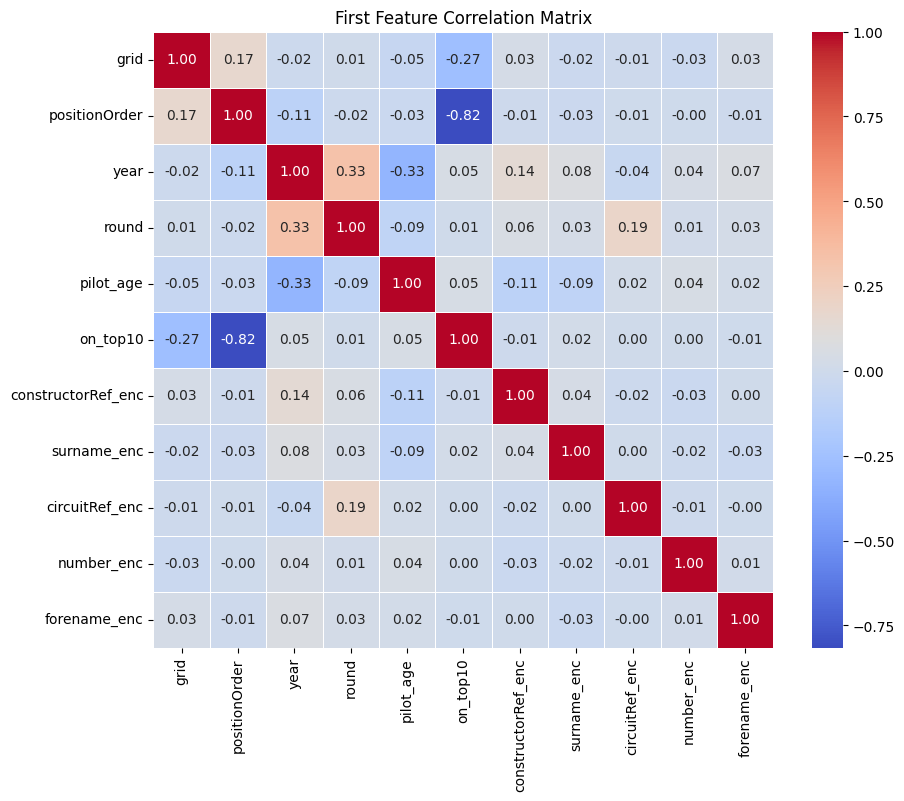

In [190]:
# Calculate the correlation matrix
# Select only numerical features and compute the correlation matrix
correlation_matrix = df_merged_4_cleaned.select_dtypes(include='number').corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('First Feature Correlation Matrix')
plt.show()

In [191]:
features=['grid','constructorRef_enc','surname_enc','round','number_enc','circuitRef_enc','pilot_age','driver_home_race',
          'constructor_home_race','year','forename_enc']

In [192]:
X = df_merged_4_cleaned[features]
y = df_merged_4_cleaned['on_top10']

In [193]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Random Forest

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      3120
           1       0.64      0.59      0.62      2296

    accuracy                           0.69      5416
   macro avg       0.68      0.68      0.68      5416
weighted avg       0.69      0.69      0.69      5416



<Axes: >

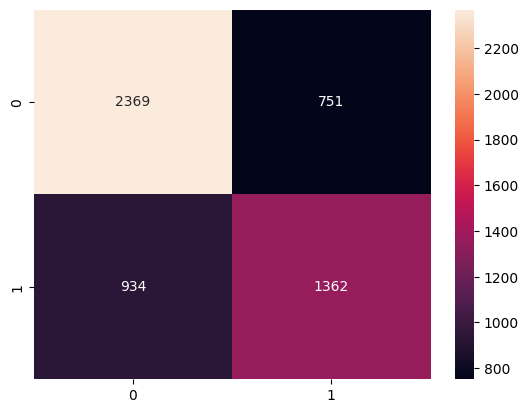

In [194]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

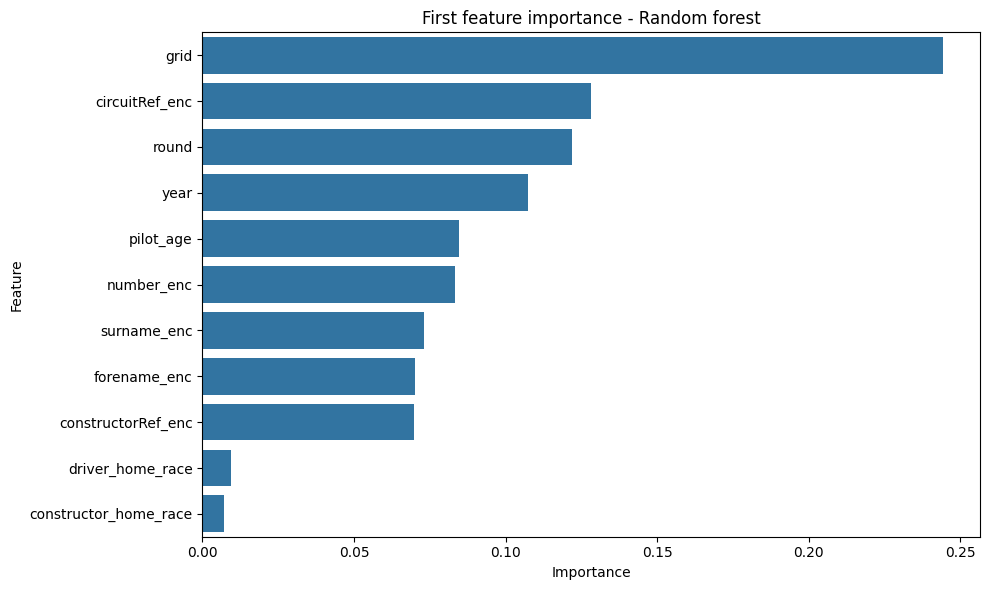

In [195]:
# Features importance

feature_names = X_train.columns

importances = model.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("First feature importance - Random forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### CatBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'border_count': 64, 'depth': 8, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      3120
           1       0.66      0.65      0.65      2296

    accuracy                           0.71      5416
   macro avg       0.70      0.70      0.70      5416
weighted avg       0.71      0.71      0.71      5416



<Axes: >

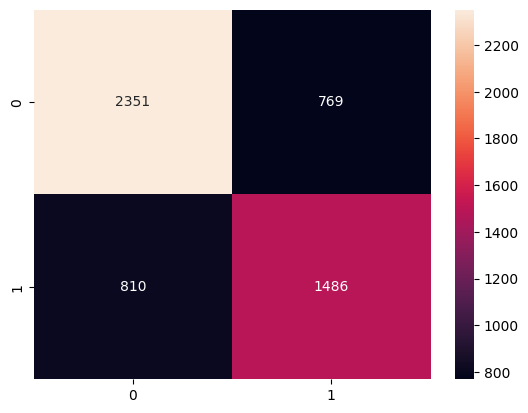

In [196]:

cat = CatBoostClassifier(random_seed=42,logging_level='Silent', train_dir=None)

param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64] 
}

grid_search = GridSearchCV(estimator=cat, param_grid=param_grid,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)


grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_cat = grid_search.best_estimator_

y_pred_cat = best_cat.predict(X_test)

# Evaluation

print(classification_report(y_test, y_pred_cat))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt='d')

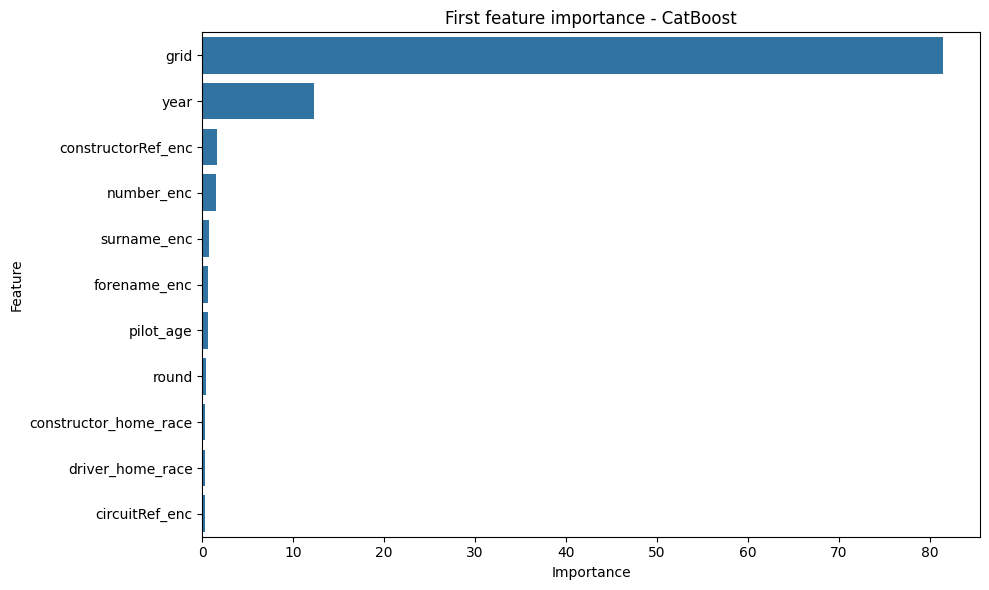

In [197]:
# Feature importance

feature_names = X_train.columns

importances = best_cat.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("First feature importance - CatBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

*Model Interpretation and Regularization Strategy*

The feature importance analysis revealed a critical insight: the model is heavily reliant on just one or two features. While the overall performance metrics appear acceptable, this strong dependency could indicate underlying issues such as feature imbalance, overfitting, or redundancy in the dataset.

To address this, I plan to increase the l2_leaf_reg parameter in CatBoost. This adds stronger L2 regularization to the model, which should encourage it to spread importance more evenly across features rather than overfitting to a small subset. By doing so, I aim to improve the model’s generalization and reduce its sensitivity to specific features.

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'border_count': 32, 'depth': 4, 'iterations': 200, 'l2_leaf_reg': 20, 'learning_rate': 0.05}
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      3120
           1       0.66      0.64      0.65      2296

    accuracy                           0.71      5416
   macro avg       0.70      0.70      0.70      5416
weighted avg       0.71      0.71      0.71      5416



<Axes: >

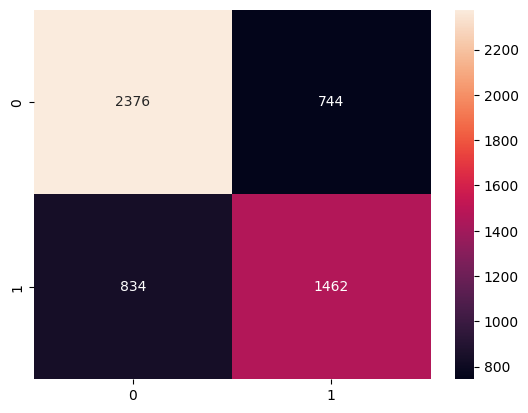

In [198]:
param_grid_2 = {
    'iterations': [200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05],
    'l2_leaf_reg': [3, 5, 10, 20, 50, 100],  # <- aqui é o foco
    'border_count': [32],
}

grid_search_2 = GridSearchCV(
    estimator=CatBoostClassifier(random_seed=42, logging_level='Silent'),
    param_grid=param_grid_2,
    scoring='f1',  # ou outro
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search_2.fit(X_train, y_train)

print("Best parameters:", grid_search_2.best_params_)

best_cat_2 = grid_search_2.best_estimator_

y_pred_cat_2 = best_cat_2.predict(X_test)

# Evaluation

print(classification_report(y_test, y_pred_cat_2))
sns.heatmap(confusion_matrix(y_test, y_pred_cat_2), annot=True, fmt='d')

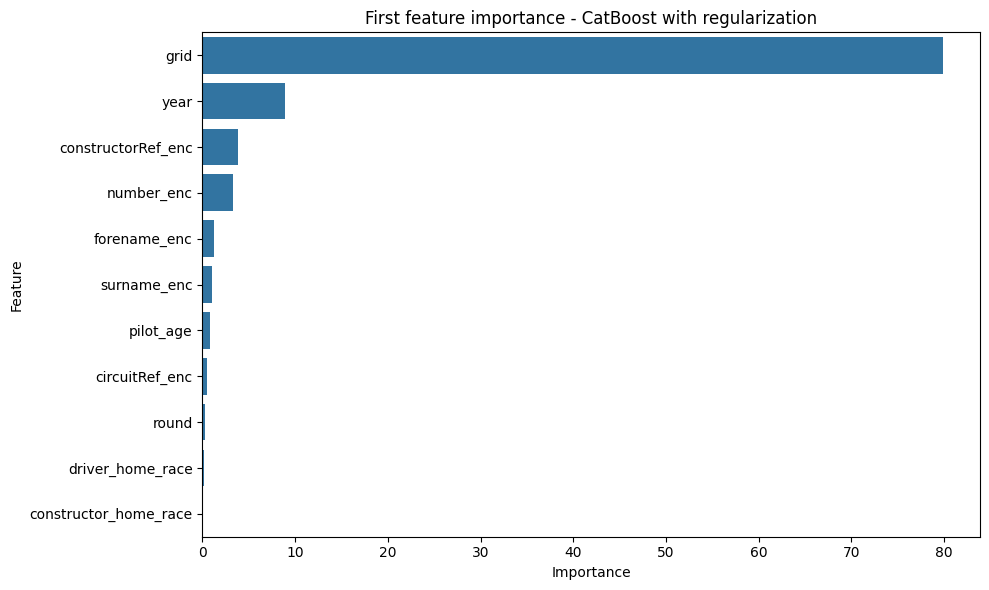

In [199]:
# Feature importance

importances = best_cat_2.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20])
plt.title("First feature importance - CatBoost with regularization")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

*Further Evaluation Without Dominant Feature*

Even after increasing the l2_leaf_reg parameter to strengthen regularization, the model still shows a high dependency on the grid feature. This continued dominance suggests that the model may be overly reliant on this variable, potentially masking the predictive power of other features.

To better assess the model's behavior and ensure more balanced learning, I will run a new experiment excluding the grid feature entirely. This will help evaluate whether the model can maintain reasonable performance without relying on this single dominant input.

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'border_count': 32, 'depth': 8, 'iterations': 200, 'l2_leaf_reg': 10, 'learning_rate': 0.05}
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      3120
           1       0.67      0.48      0.56      2296

    accuracy                           0.68      5416
   macro avg       0.68      0.65      0.65      5416
weighted avg       0.68      0.68      0.67      5416



<Axes: >

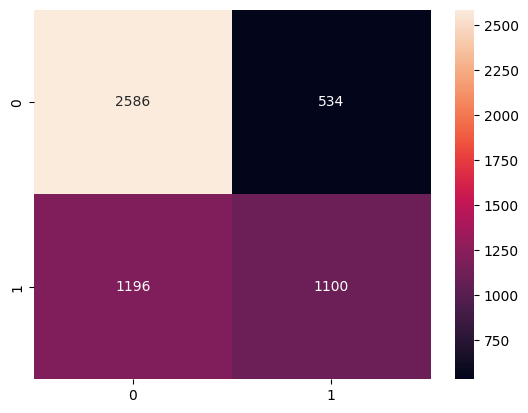

In [200]:
X_train_nogrid = X_train.drop(columns=['grid'])

grid_search_2.fit(X_train_nogrid, y_train)

print("Best parameters:", grid_search_2.best_params_)

best_cat_2 = grid_search_2.best_estimator_

y_pred_cat_2 = best_cat_2.predict(X_test)

# Evaluation

print(classification_report(y_test, y_pred_cat_2))
sns.heatmap(confusion_matrix(y_test, y_pred_cat_2), annot=True, fmt='d')

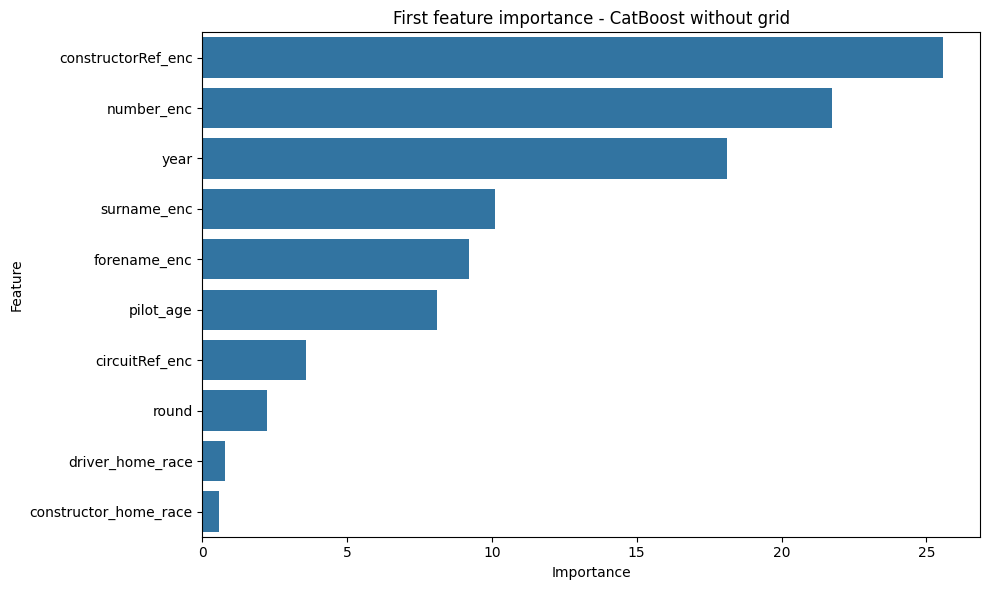

In [201]:
# Feature importance

importances = best_cat_2.feature_importances_
feat_imp = pd.Series(importances, index=X_train_nogrid.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20])
plt.title("First feature importance - CatBoost without grid")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Second feature engineering

In [44]:
df_merged_4_cleaned= df_merged_4_cleaned.sort_values(['driverId', 'year', 'round'])

In [45]:
df_merged_4_cleaned['driver_podiums_before'] = (
    df_merged_4_cleaned.groupby('driverId')['on_top10'].cumsum().shift(1).fillna(0)
)

df_merged_4_cleaned['driver_races_before'] = (
    df_merged_4_cleaned.groupby('driverId').cumcount()
)

df_merged_4_cleaned['driver_avg_finish_before'] = (
    df_merged_4_cleaned.groupby('driverId')['positionOrder']
    .transform(lambda x: x.shift(1).expanding().mean()).fillna(0)
)

In [46]:
df_merged_4_cleaned['constructor_podiums_before'] = (
    df_merged_4_cleaned.groupby('constructorId')['on_top10'].cumsum().shift(1).fillna(0)
)

df_merged_4_cleaned['constructor_races_before'] = (
    df_merged_4_cleaned.groupby('constructorId').cumcount()
)

df_merged_4_cleaned['constructor_avg_finish_before'] = (
    df_merged_4_cleaned.groupby('constructorId')['positionOrder']
    .transform(lambda x: x.shift(1).expanding().mean()).fillna(0)
)

In [47]:
df_merged_4_cleaned['driver_track_avg'] = (
    df_merged_4_cleaned
    .groupby(['driverId', 'circuitId'])['positionOrder']
    .transform(lambda x: x.shift(1).expanding().mean())
    .fillna(df_merged_4_cleaned['driver_avg_finish_before'])  # fallback
)

In [48]:
df_merged_4_cleaned['constructor_track_avg'] = (
    df_merged_4_cleaned
    .groupby(['constructorId', 'circuitId'])['positionOrder']
    .transform(lambda x: x.shift(1).expanding().mean())
    .fillna(df_merged_4_cleaned['constructor_avg_finish_before'])
)

In [207]:
df_merged_4_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27078 entries, 370 to 27067
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   raceId                         27078 non-null  category
 1   driverId                       27078 non-null  category
 2   constructorId                  27078 non-null  category
 3   number                         27078 non-null  object  
 4   grid                           27078 non-null  int64   
 5   positionOrder                  27078 non-null  int64   
 6   constructorRef                 27078 non-null  object  
 7   forename                       27078 non-null  object  
 8   surname                        27078 non-null  object  
 9   year                           27078 non-null  int64   
 10  round                          27078 non-null  int64   
 11  circuitId                      27078 non-null  category
 12  circuitRef                     2707

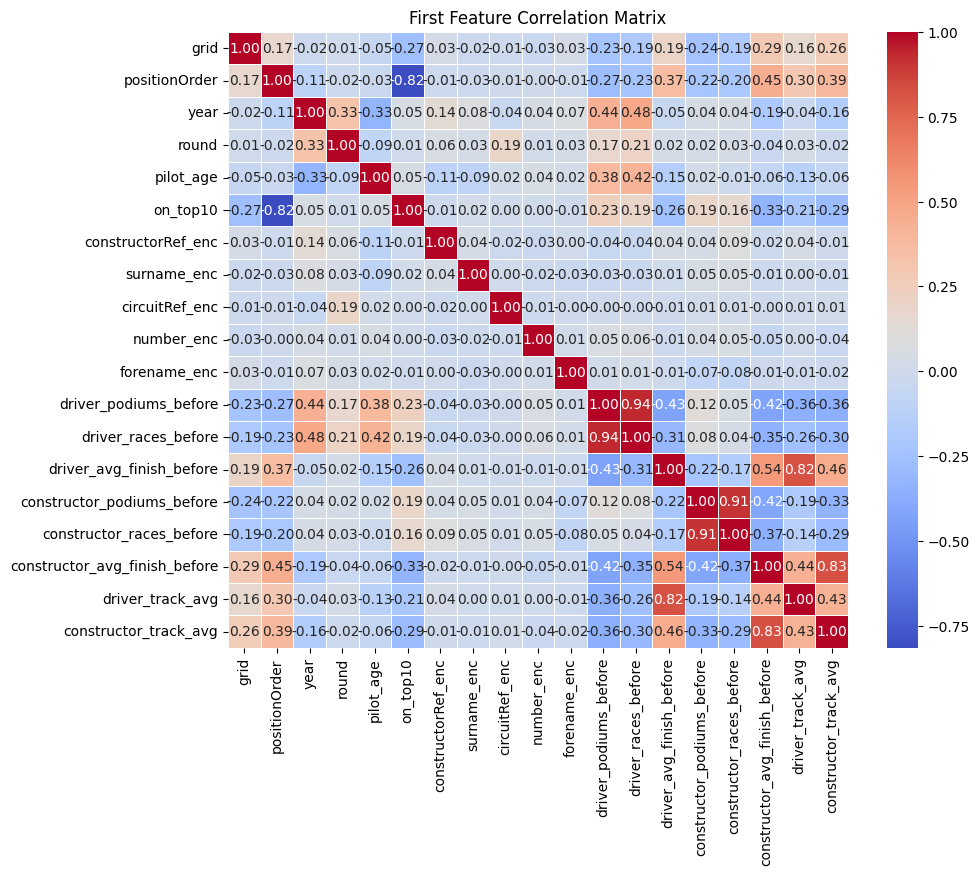

In [208]:
# Calculate the correlation matrix
# Select only numerical features and compute the correlation matrix
correlation_matrix = df_merged_4_cleaned.select_dtypes(include='number').corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('First Feature Correlation Matrix')
plt.show()

### Second training and modeling

In [49]:
features_2=['number_enc','constructor_races_before',
            'driver_avg_finish_before','driver_races_before','constructor_avg_finish_before','constructor_track_avg',
            'driver_track_avg','grid','constructorRef_enc','surname_enc','round','circuitRef_enc','pilot_age','driver_home_race',
            'constructor_home_race','forename_enc']

In [50]:
X_2 = df_merged_4_cleaned[features_2]
y_2 = df_merged_4_cleaned['on_top10']

In [51]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2, y_2, test_size=0.2, random_state=42, stratify=y_2
)

#### Random Forest

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      3120
           1       0.67      0.60      0.63      2296

    accuracy                           0.70      5416
   macro avg       0.70      0.69      0.69      5416
weighted avg       0.70      0.70      0.70      5416



<Axes: >

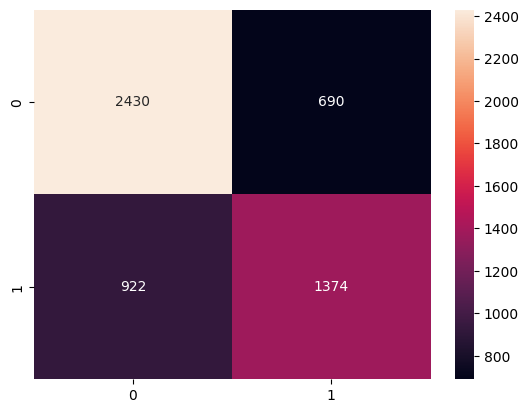

In [212]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_2, y_train_2)
y_pred_2 = model.predict(X_test_2)

print(classification_report(y_test_2, y_pred_2))
sns.heatmap(confusion_matrix(y_test_2, y_pred_2), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12477
           1       1.00      1.00      1.00      9185

    accuracy                           1.00     21662
   macro avg       1.00      1.00      1.00     21662
weighted avg       1.00      1.00      1.00     21662



<Axes: >

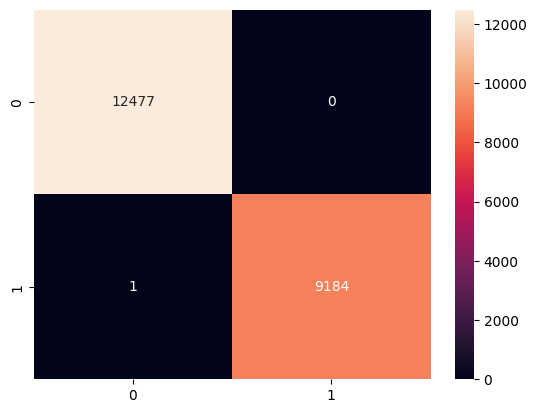

In [213]:
y_pred_2 = model.predict(X_train_2)

print(classification_report(y_train_2, y_pred_2))
sns.heatmap(confusion_matrix(y_train_2, y_pred_2), annot=True, fmt='d')

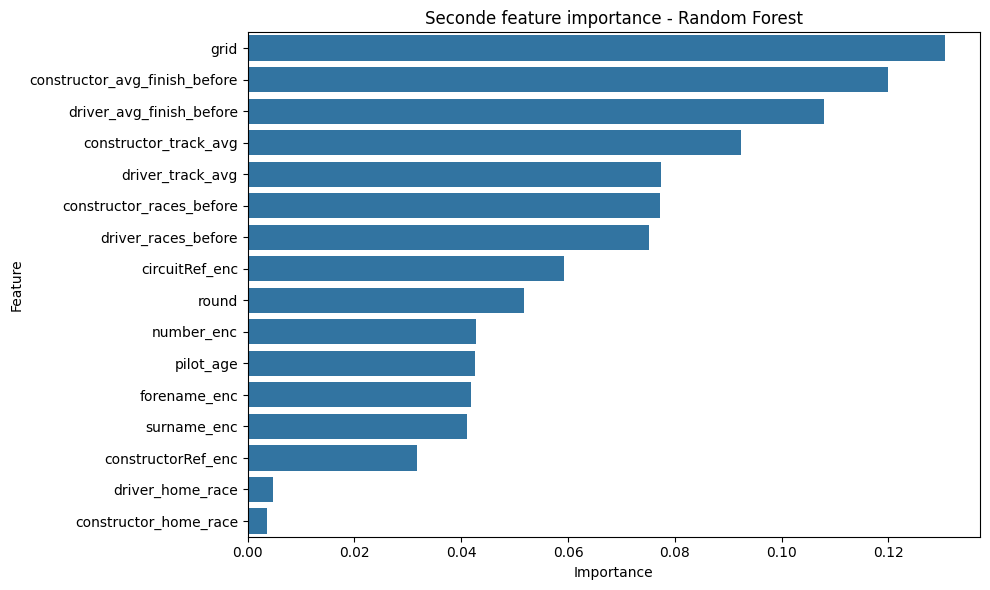

In [214]:
# Feature importance

feature_names = X_train_2.columns

importances = model.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Seconde feature importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### CatBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'border_count': 64, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      3120
           1       0.67      0.63      0.65      2296

    accuracy                           0.71      5416
   macro avg       0.70      0.70      0.70      5416
weighted avg       0.71      0.71      0.71      5416



<Axes: >

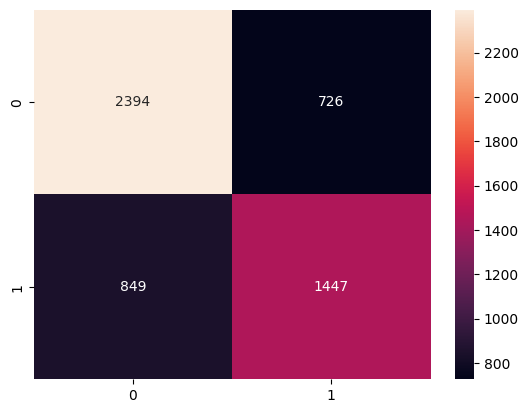

In [215]:
cat = CatBoostClassifier(random_seed=42,logging_level='Silent', train_dir=None)

param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64]
}

grid_search = GridSearchCV(estimator=cat, param_grid=param_grid,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train_2, y_train_2)

print("Best parameters:", grid_search.best_params_)

best_cat_2 = grid_search.best_estimator_

y_pred_cat_2 = best_cat_2.predict(X_test_2)

# Evaluation

print(classification_report(y_test_2, y_pred_cat_2))
sns.heatmap(confusion_matrix(y_test_2, y_pred_cat_2), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.74      0.76      0.75     12477
           1       0.66      0.64      0.65      9185

    accuracy                           0.71     21662
   macro avg       0.70      0.70      0.70     21662
weighted avg       0.71      0.71      0.71     21662



<Axes: >

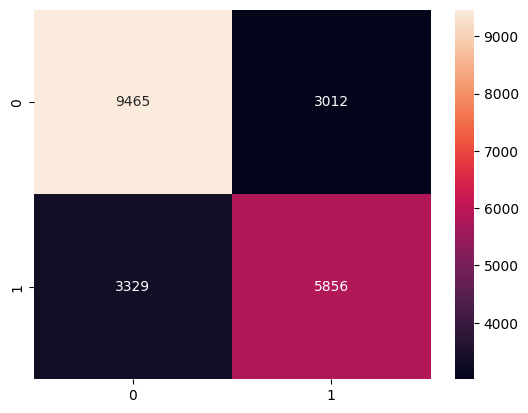

In [216]:
y_pred_cat_2 = best_cat_2.predict(X_train_2)

print(classification_report(y_train_2, y_pred_cat_2))
sns.heatmap(confusion_matrix(y_train_2, y_pred_cat_2), annot=True, fmt='d')

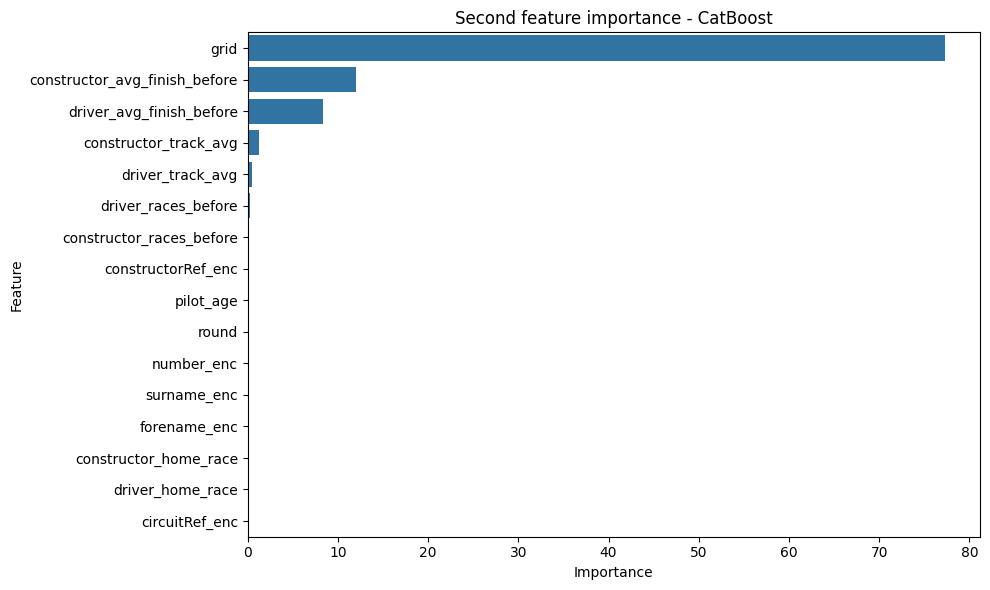

In [217]:
# Feature importance

feature_names = X_train_2.columns

importances = best_cat_2.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Second feature importance - CatBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'border_count': 32, 'depth': 8, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
              precision    recall  f1-score   support

           0       0.71      0.79      0.74      3120
           1       0.66      0.56      0.60      2296

    accuracy                           0.69      5416
   macro avg       0.68      0.67      0.67      5416
weighted avg       0.69      0.69      0.68      5416



<Axes: >

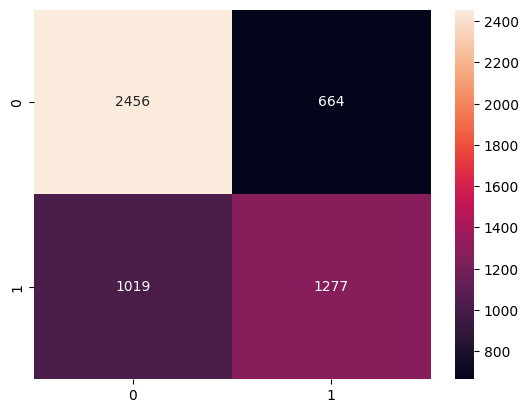

In [218]:
# Checking again without grid

X_train_nogrid_2 = X_train_2.drop(columns=['grid'])

grid_search_2.fit(X_train_nogrid_2, y_train_2)

print("Best parameters:", grid_search_2.best_params_)

best_cat_2 = grid_search_2.best_estimator_

y_pred_cat_2 = best_cat_2.predict(X_test_2)

# Evaluation

print(classification_report(y_test_2, y_pred_cat_2))
sns.heatmap(confusion_matrix(y_test_2, y_pred_cat_2), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.76      0.82      0.79     12477
           1       0.72      0.64      0.68      9185

    accuracy                           0.74     21662
   macro avg       0.74      0.73      0.73     21662
weighted avg       0.74      0.74      0.74     21662



<Axes: >

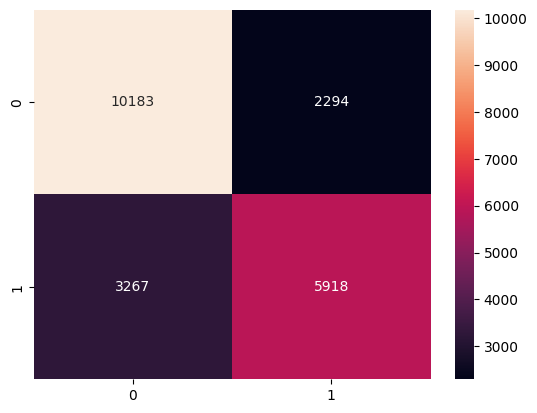

In [219]:
y_pred_cat_2 = best_cat_2.predict(X_train_2)

# Evaluation

print(classification_report(y_train_2, y_pred_cat_2))
sns.heatmap(confusion_matrix(y_train_2, y_pred_cat_2), annot=True, fmt='d')

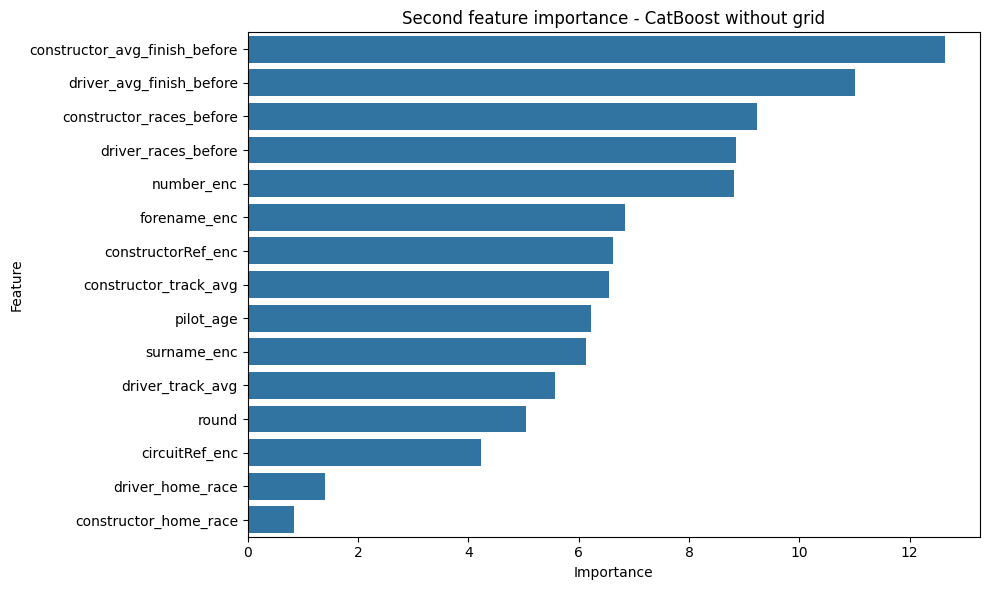

In [220]:
# Feature importance

importances = best_cat_2.feature_importances_
feat_imp = pd.Series(importances, index=X_train_nogrid_2.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20])
plt.title("Second feature importance - CatBoost without grid")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### XGB Classifier

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 5}
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      3120
           1       0.67      0.62      0.65      2296

    accuracy                           0.71      5416
   macro avg       0.70      0.70      0.70      5416
weighted avg       0.71      0.71      0.71      5416



<Axes: >

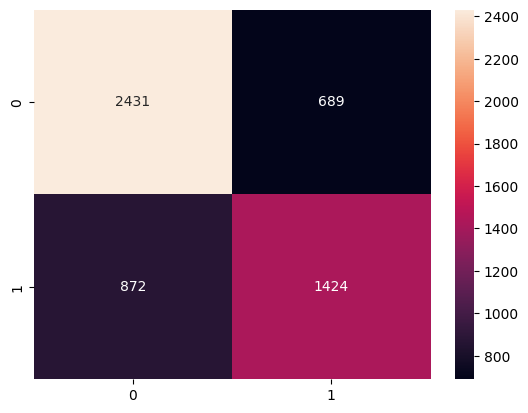

In [221]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_lambda': [1, 3, 5],
    'gamma': [0, 1], 
}

grid_search_xgb = GridSearchCV(estimator=xgb,
                           param_grid=param_grid_xgb,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search_xgb.fit(X_train_2, y_train_2)


print("Best parameters:", grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(X_test_2)

# Evaluation

print(classification_report(y_test_2, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test_2, y_pred_xgb), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.76      0.79      0.78     12477
           1       0.70      0.67      0.68      9185

    accuracy                           0.74     21662
   macro avg       0.73      0.73      0.73     21662
weighted avg       0.74      0.74      0.74     21662



<Axes: >

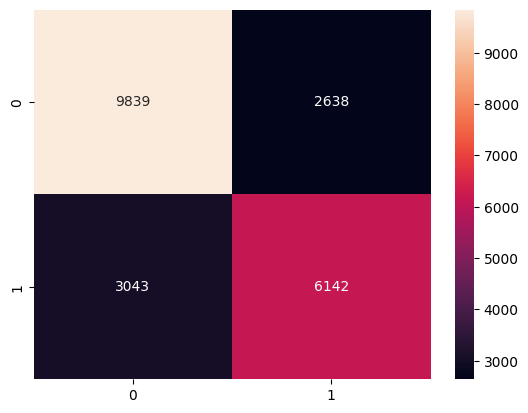

In [222]:
y_pred_xgb = best_xgb.predict(X_train_2)

# Evaluation

print(classification_report(y_train_2, y_pred_xgb))
sns.heatmap(confusion_matrix(y_train_2, y_pred_xgb), annot=True, fmt='d')

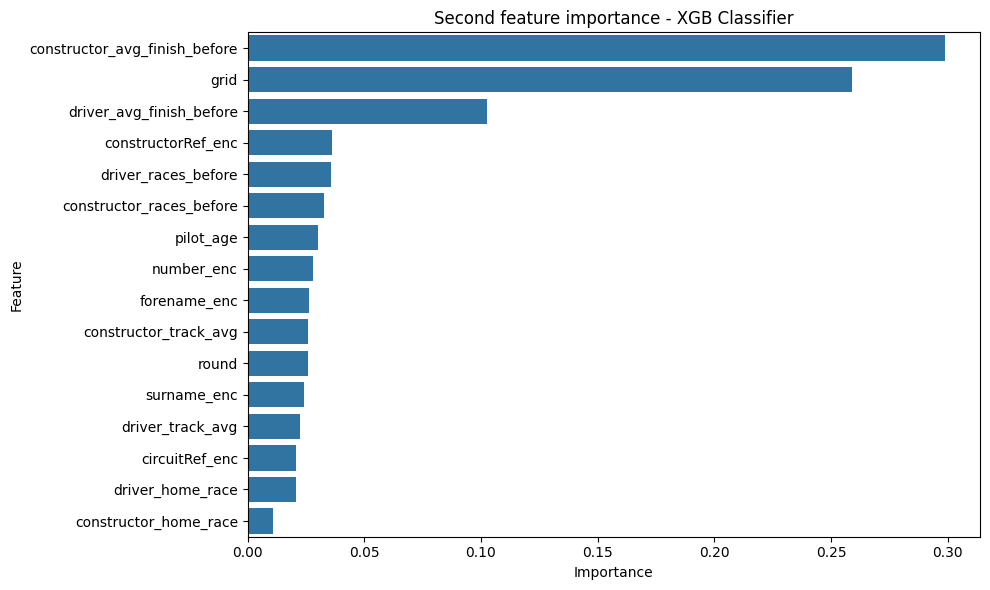

In [223]:
# Feature importance

importances = best_xgb.feature_importances_
feat_imp = pd.Series(importances, index=X_train_2.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Second feature importance - XGB Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Testing balancing techniques

In [54]:
# SMOTE + ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X_train_2, y_train_2)

# SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_resampled_tomek, y_resampled_tomek = smote_tomek.fit_resample(X_train_2, y_train_2)

# ADASYN
adasyn = ADASYN(random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train_2, y_train_2)

#### SMOTE + ENN and CatBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'border_count': 32, 'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      3120
           1       0.62      0.72      0.66      2296

    accuracy                           0.69      5416
   macro avg       0.69      0.69      0.69      5416
weighted avg       0.70      0.69      0.69      5416



<Axes: >

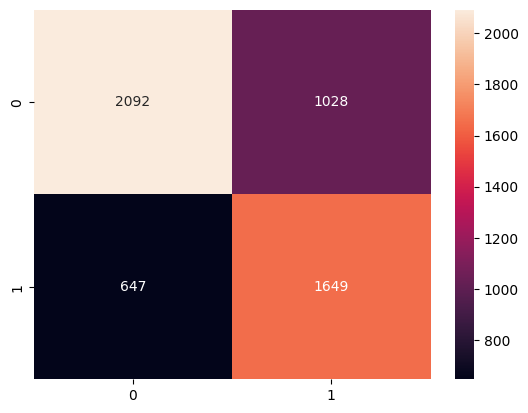

In [225]:
cat = CatBoostClassifier(random_seed=42,logging_level='Silent', train_dir=None)

param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64]
}

grid_search = GridSearchCV(estimator=cat, param_grid=param_grid,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_resampled_enn, y_resampled_enn)

print("Best parameters:", grid_search.best_params_)

best_cat_enn = grid_search.best_estimator_

y_pred_cat_enn = best_cat_enn.predict(X_test_2)

# Evaluation

print(classification_report(y_test_2, y_pred_cat_enn))
sns.heatmap(confusion_matrix(y_test_2, y_pred_cat_enn), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.81      0.70      0.76     12477
           1       0.66      0.78      0.72      9185

    accuracy                           0.74     21662
   macro avg       0.74      0.74      0.74     21662
weighted avg       0.75      0.74      0.74     21662



<Axes: >

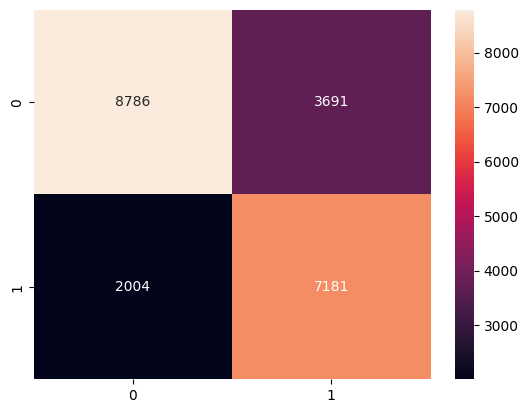

In [226]:
y_pred_cat_enn = best_cat_enn.predict(X_train_2)

print(classification_report(y_train_2, y_pred_cat_enn))
sns.heatmap(confusion_matrix(y_train_2, y_pred_cat_enn), annot=True, fmt='d')

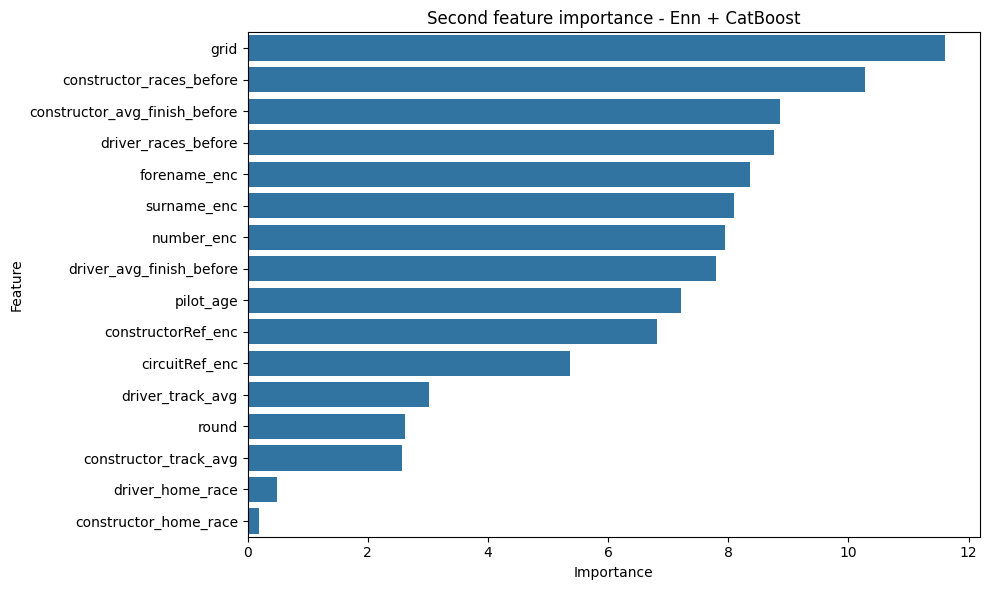

In [227]:
# Feature importance

importances = best_cat_enn.feature_importances_
feat_imp = pd.Series(importances, index=X_train_2.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Second feature importance - Enn + CatBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### SMOTE + Tomek Links and CatBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'border_count': 32, 'depth': 8, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.2}
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      3120
           1       0.63      0.66      0.65      2296

    accuracy                           0.69      5416
   macro avg       0.68      0.69      0.69      5416
weighted avg       0.69      0.69      0.69      5416



<Axes: >

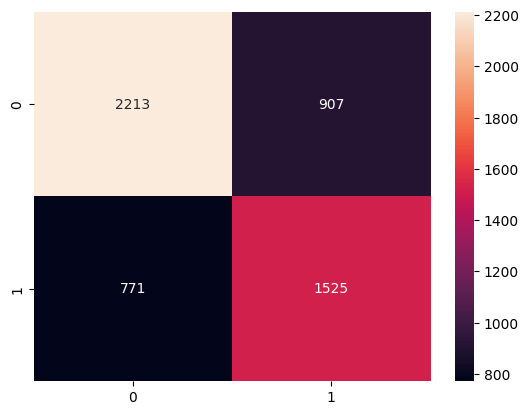

In [228]:

cat = CatBoostClassifier(random_seed=42,logging_level='Silent', train_dir=None)

param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64]
}

grid_search = GridSearchCV(estimator=cat, param_grid=param_grid,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_resampled_tomek, y_resampled_tomek)

print("Best parameters:", grid_search.best_params_)

best_cat_tomek = grid_search.best_estimator_

y_pred_cat_tomek = best_cat_tomek.predict(X_test_2)

# Evaluation

print(classification_report(y_test_2, y_pred_cat_tomek))
sns.heatmap(confusion_matrix(y_test_2, y_pred_cat_tomek), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.89      0.84      0.87     12477
           1       0.80      0.86      0.83      9185

    accuracy                           0.85     21662
   macro avg       0.85      0.85      0.85     21662
weighted avg       0.85      0.85      0.85     21662



<Axes: >

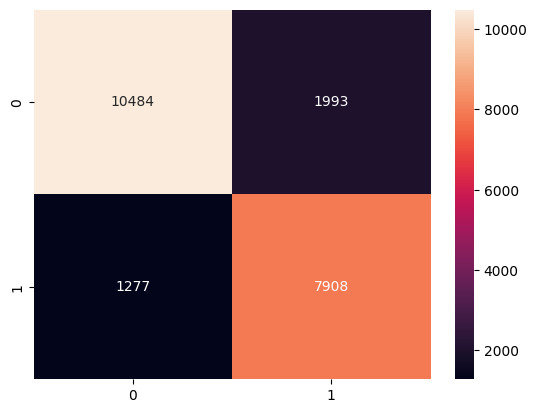

In [229]:
y_pred_cat_tomek = best_cat_tomek.predict(X_train_2)

print(classification_report(y_train_2, y_pred_cat_tomek))
sns.heatmap(confusion_matrix(y_train_2, y_pred_cat_tomek), annot=True, fmt='d')

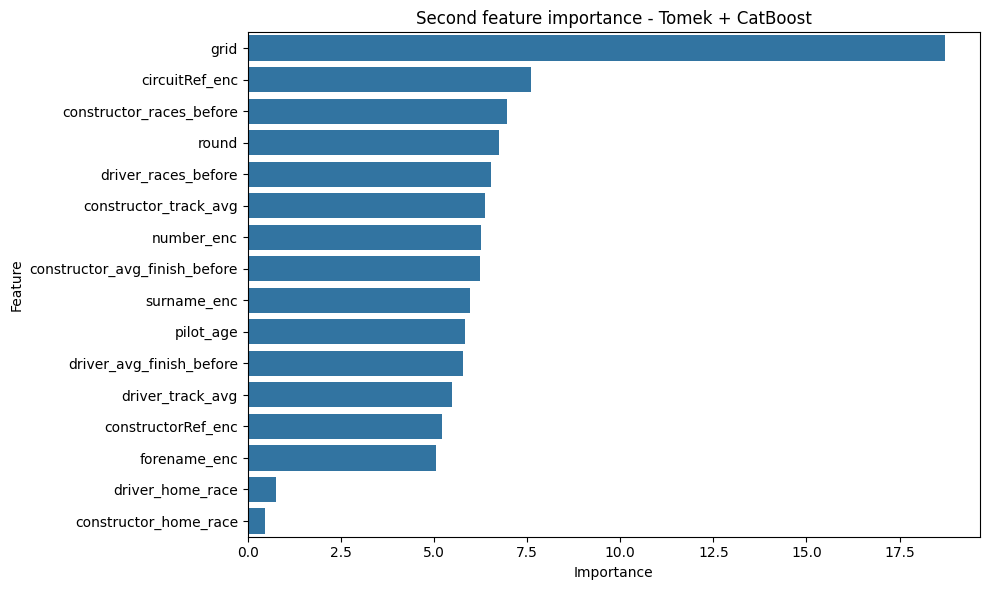

In [230]:
# Feature importance

importances = best_cat_tomek.feature_importances_
feat_imp = pd.Series(importances, index=X_train_2.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Second feature importance - Tomek + CatBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### ADASYN and CatBoost

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'border_count': 32, 'depth': 8, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      3120
           1       0.63      0.70      0.66      2296

    accuracy                           0.70      5416
   macro avg       0.69      0.70      0.69      5416
weighted avg       0.70      0.70      0.70      5416



<Axes: >

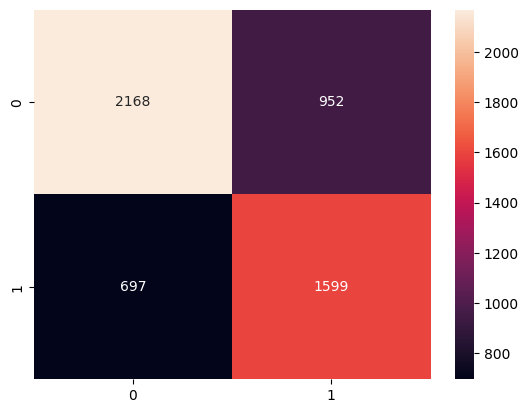

In [231]:

cat = CatBoostClassifier(random_seed=42,logging_level='Silent', train_dir=None)

param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64]
}

grid_search = GridSearchCV(estimator=cat, param_grid=param_grid,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_resampled_adasyn, y_resampled_adasyn)

print("Best parameters:", grid_search.best_params_)

best_cat_ada = grid_search.best_estimator_

y_pred_cat_ada = best_cat_ada.predict(X_test_2)

# Evaluation

print(classification_report(y_test_2, y_pred_cat_ada))
sns.heatmap(confusion_matrix(y_test_2, y_pred_cat_ada), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.88      0.80      0.84     12477
           1       0.76      0.85      0.80      9185

    accuracy                           0.82     21662
   macro avg       0.82      0.82      0.82     21662
weighted avg       0.83      0.82      0.82     21662



<Axes: >

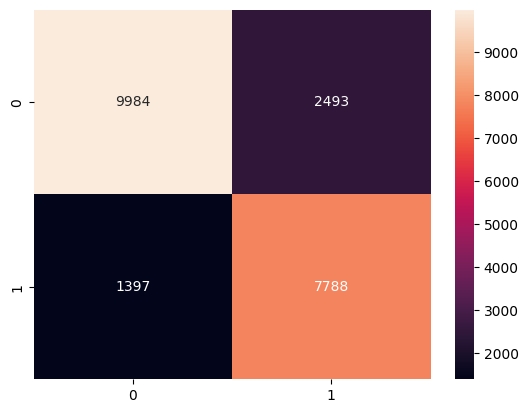

In [232]:
y_pred_cat_ada = best_cat_ada.predict(X_train_2)

print(classification_report(y_train_2, y_pred_cat_ada))
sns.heatmap(confusion_matrix(y_train_2, y_pred_cat_ada), annot=True, fmt='d')

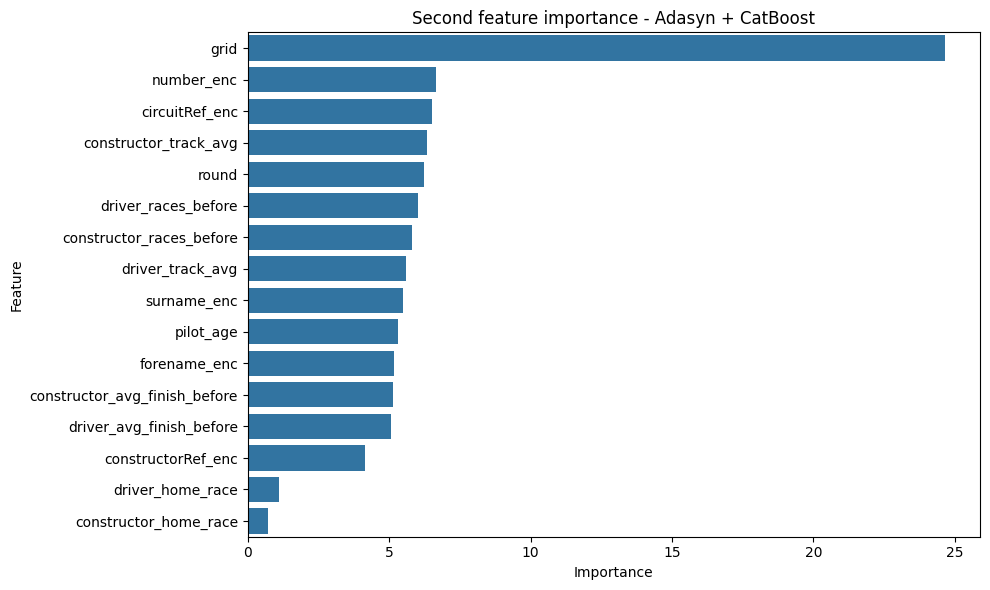

In [233]:
# Feature importance

importances = best_cat_ada.feature_importances_
feat_imp = pd.Series(importances, index=X_train_2.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Second feature importance - Adasyn + CatBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### SMOTE + ENN and XGB

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 5}
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      3120
           1       0.62      0.72      0.67      2296

    accuracy                           0.69      5416
   macro avg       0.69      0.70      0.69      5416
weighted avg       0.70      0.69      0.70      5416



<Axes: >

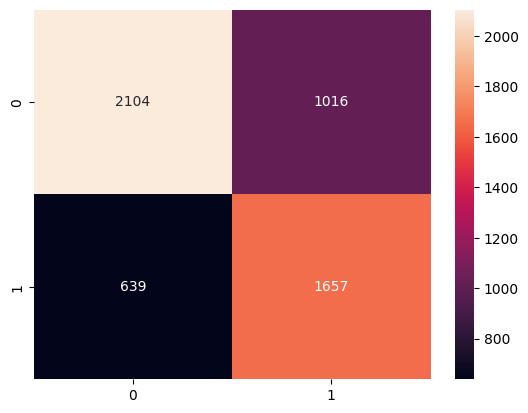

In [234]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_lambda': [1, 3, 5],
    'gamma': [0, 1], 
}

grid_search_xgb = GridSearchCV(estimator=xgb,
                           param_grid=param_grid_xgb,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search_xgb.fit(X_resampled_enn, y_resampled_enn)


print("Best parameters:", grid_search_xgb.best_params_)

best_xgb_enn = grid_search_xgb.best_estimator_

y_pred_xgb_enn = best_xgb_enn.predict(X_test_2)

# Evaluation

print(classification_report(y_test_2, y_pred_xgb_enn))
sns.heatmap(confusion_matrix(y_test_2, y_pred_xgb_enn), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.81      0.71      0.76     12477
           1       0.66      0.78      0.72      9185

    accuracy                           0.74     21662
   macro avg       0.74      0.74      0.74     21662
weighted avg       0.75      0.74      0.74     21662



<Axes: >

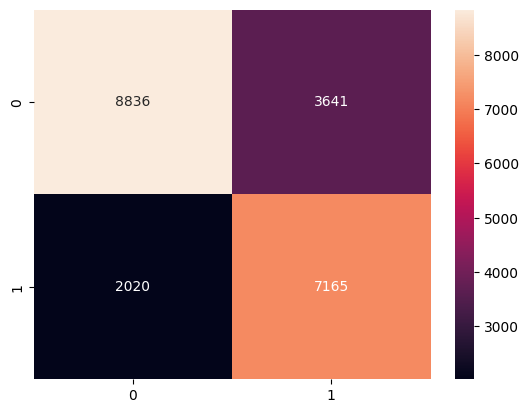

In [235]:
y_pred_xgb_enn = best_xgb_enn.predict(X_train_2)

print(classification_report(y_train_2, y_pred_xgb_enn))
sns.heatmap(confusion_matrix(y_train_2, y_pred_xgb_enn), annot=True, fmt='d')

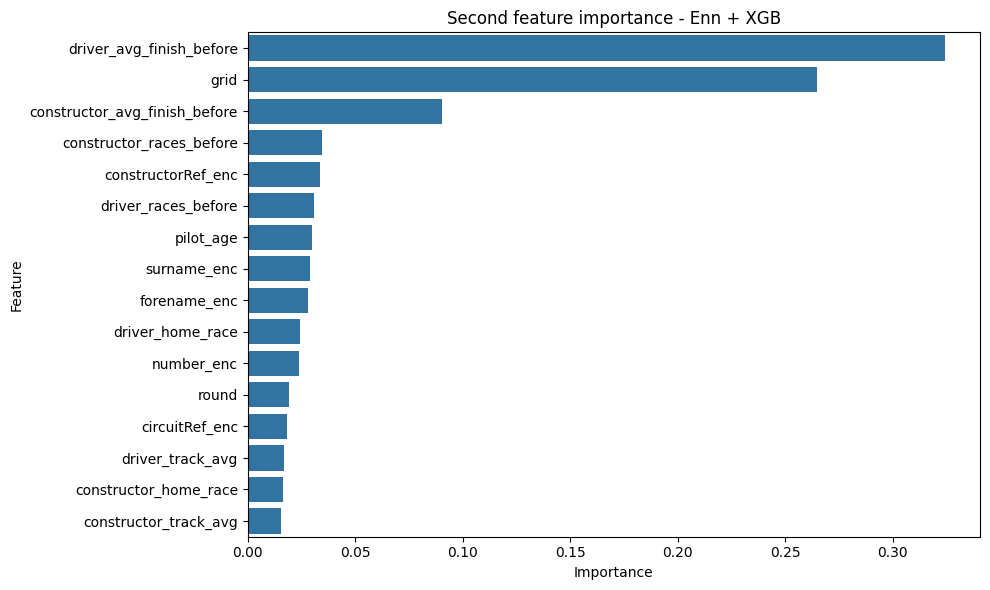

In [236]:
# Feature importance

importances = best_xgb_enn.feature_importances_
feat_imp = pd.Series(importances, index=X_train_2.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Second feature importance - Enn + XGB")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### SMOTE + Tomek Links and XGB

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 1}
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      3120
           1       0.63      0.64      0.64      2296

    accuracy                           0.69      5416
   macro avg       0.68      0.68      0.68      5416
weighted avg       0.69      0.69      0.69      5416



<Axes: >

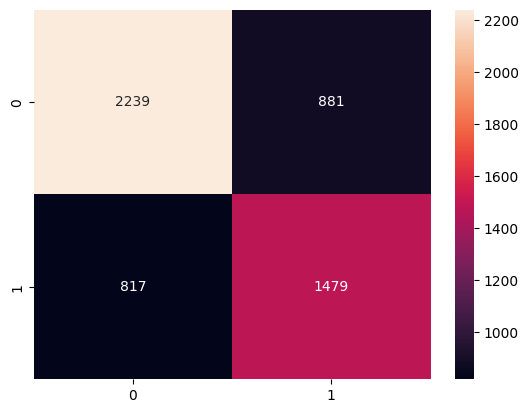

In [237]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_lambda': [1, 3, 5],
    'gamma': [0, 1], 
}

grid_search_xgb = GridSearchCV(estimator=xgb,
                           param_grid=param_grid_xgb,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search_xgb.fit(X_resampled_tomek, y_resampled_tomek)


print("Best parameters:", grid_search_xgb.best_params_)

best_xgb_tomek = grid_search_xgb.best_estimator_

y_pred_xgb_tomek = best_xgb_tomek.predict(X_test_2)

# Evaluation

print(classification_report(y_test_2, y_pred_xgb_tomek))
sns.heatmap(confusion_matrix(y_test_2, y_pred_xgb_tomek), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     12477
           1       0.89      0.91      0.90      9185

    accuracy                           0.92     21662
   macro avg       0.91      0.92      0.91     21662
weighted avg       0.92      0.92      0.92     21662



<Axes: >

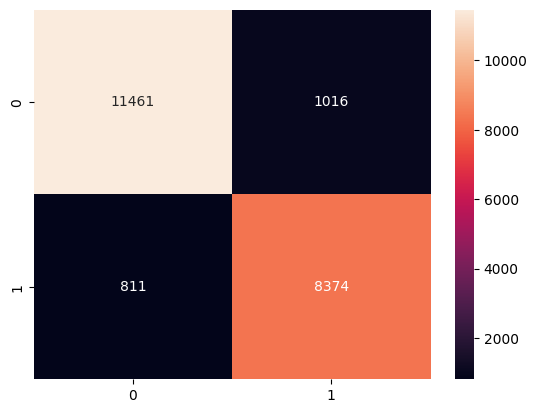

In [238]:
y_pred_xgb_tomek = best_xgb_tomek.predict(X_train_2)

print(classification_report(y_train_2, y_pred_xgb_tomek))
sns.heatmap(confusion_matrix(y_train_2, y_pred_xgb_tomek), annot=True, fmt='d')

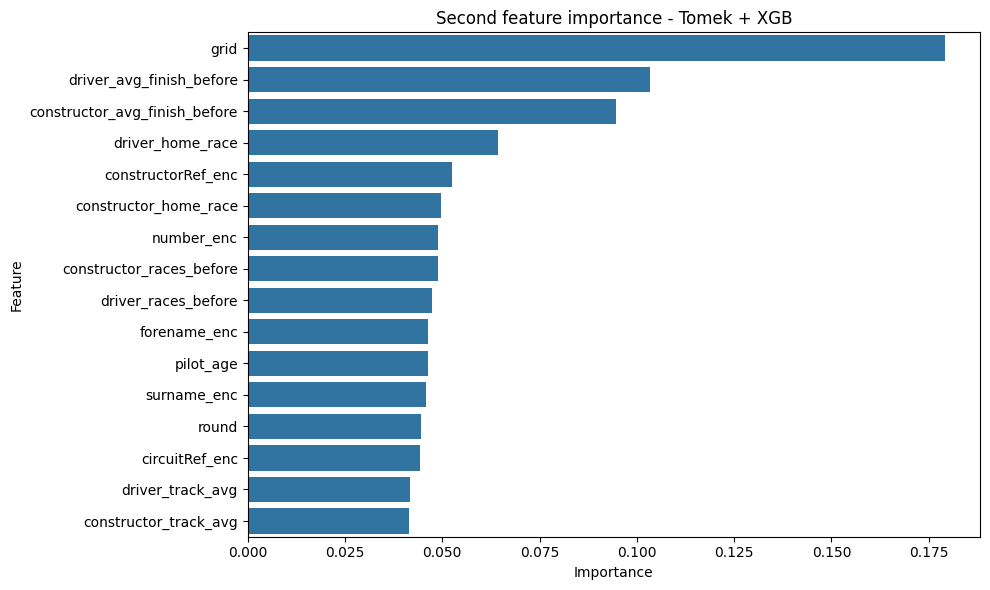

In [239]:
# Feature importance

importances = best_xgb_tomek.feature_importances_
feat_imp = pd.Series(importances, index=X_train_2.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Second feature importance - Tomek + XGB")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### ADASYN and XGB

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 5}
              precision    recall  f1-score   support

           0       0.76      0.69      0.73      3120
           1       0.63      0.71      0.67      2296

    accuracy                           0.70      5416
   macro avg       0.70      0.70      0.70      5416
weighted avg       0.71      0.70      0.70      5416



<Axes: >

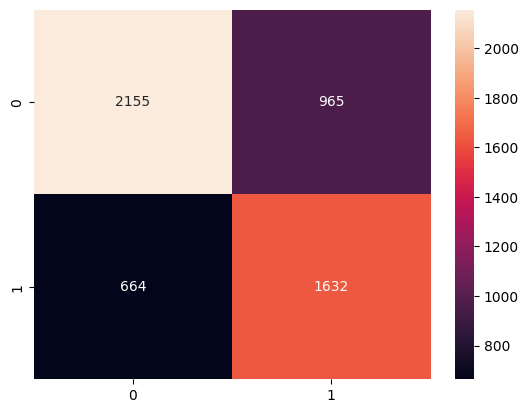

In [240]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_lambda': [1, 3, 5],
    'gamma': [0, 1], 
}

grid_search_xgb = GridSearchCV(estimator=xgb,
                           param_grid=param_grid_xgb,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search_xgb.fit(X_resampled_adasyn, y_resampled_adasyn)


print("Best parameters:", grid_search_xgb.best_params_)

best_xgb_ada = grid_search_xgb.best_estimator_

y_pred_xgb_ada = best_xgb_ada.predict(X_test_2)

# Evaluation

print(classification_report(y_test_2, y_pred_xgb_ada))
sns.heatmap(confusion_matrix(y_test_2, y_pred_xgb_ada), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.85      0.75      0.80     12477
           1       0.71      0.82      0.76      9185

    accuracy                           0.78     21662
   macro avg       0.78      0.79      0.78     21662
weighted avg       0.79      0.78      0.78     21662



<Axes: >

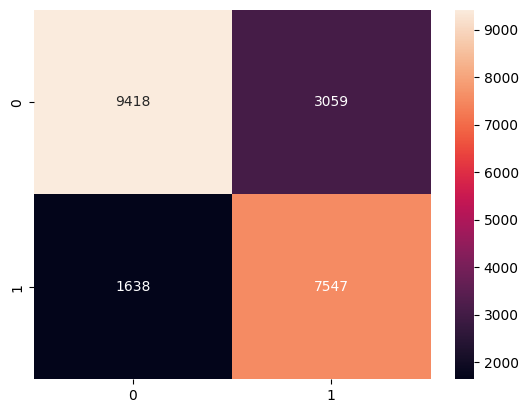

In [241]:
y_pred_xgb_ada = best_xgb_ada.predict(X_train_2)

print(classification_report(y_train_2, y_pred_xgb_ada))
sns.heatmap(confusion_matrix(y_train_2, y_pred_xgb_ada), annot=True, fmt='d')

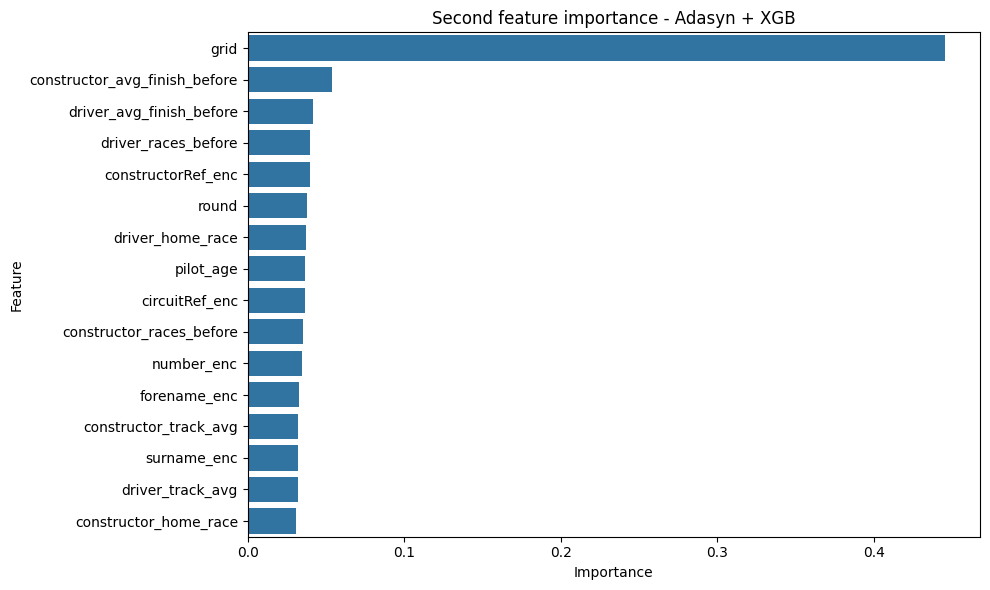

In [242]:
# Feature importance

importances = best_xgb_ada.feature_importances_
feat_imp = pd.Series(importances, index=X_train_2.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Second feature importance - Adasyn + XGB")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 3}
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      3120
           1       0.64      0.72      0.68      2296

    accuracy                           0.71      5416
   macro avg       0.70      0.71      0.70      5416
weighted avg       0.71      0.71      0.71      5416



<Axes: >

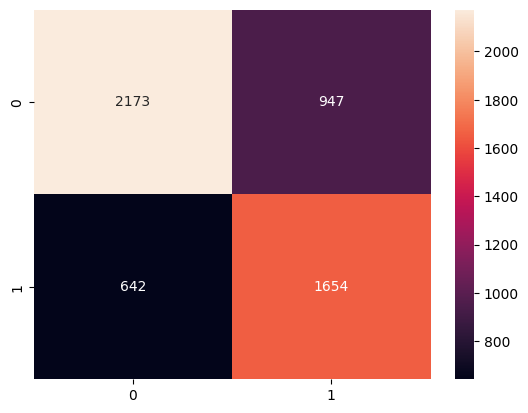

In [ ]:
## Scale_pos_weight

xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1.0
)


param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'reg_lambda': [1, 3],
    'gamma': [0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_resampled_adasyn, y_resampled_adasyn)

print("Best parameters:", grid_search_xgb.best_params_)

best_xgb_ada_bal = grid_search_xgb.best_estimator_

y_pred_xgb_ada = best_xgb_ada_bal.predict(X_test_2)

print(classification_report(y_test_2, y_pred_xgb_ada))
sns.heatmap(confusion_matrix(y_test_2, y_pred_xgb_ada), annot=True, fmt='d')

              precision    recall  f1-score   support

           0       0.79      0.71      0.75     12477
           1       0.65      0.75      0.70      9185

    accuracy                           0.72     21662
   macro avg       0.72      0.73      0.72     21662
weighted avg       0.73      0.72      0.73     21662



<Axes: >

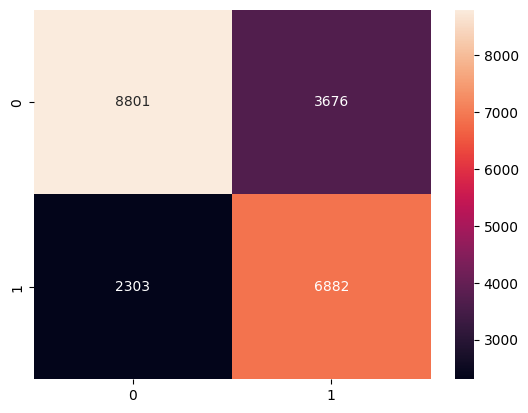

In [61]:
y_pred_xgb_ada_bal = best_xgb_ada_bal.predict(X_train_2)

print(classification_report(y_train_2, y_pred_xgb_ada_bal))
sns.heatmap(confusion_matrix(y_train_2, y_pred_xgb_ada_bal), annot=True, fmt='d')

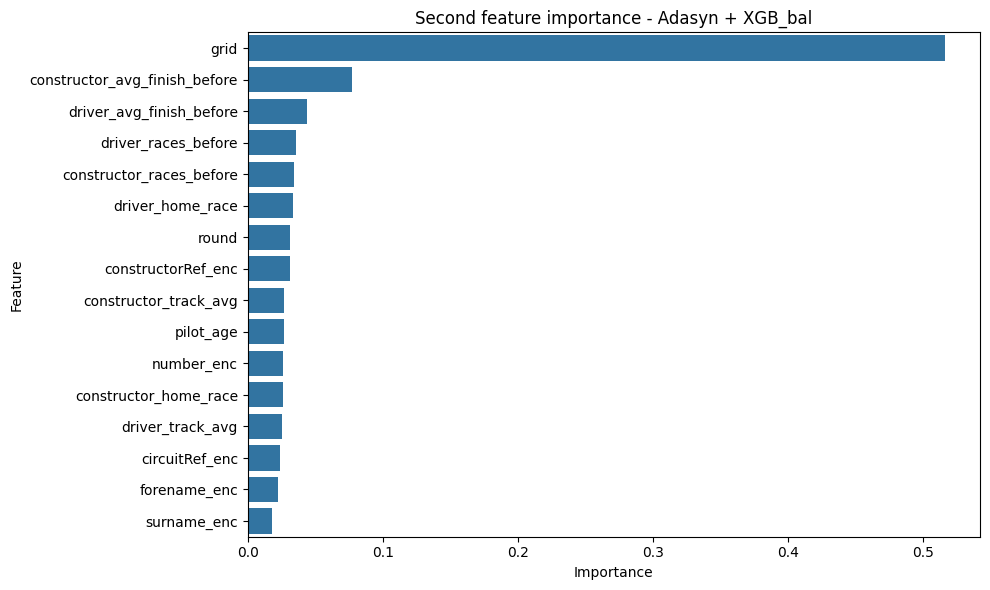

In [62]:
# Feature importance

importances = best_xgb_ada_bal.feature_importances_
feat_imp = pd.Series(importances, index=X_train_2.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:], y=feat_imp.index[:])
plt.title("Second feature importance - Adasyn + XGB_bal")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()